In [54]:
import numpy as np
import pandas as pd
import json
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### How do we predict what rating a user is going to give?
1) Business side:
    - location
    - type
    - hours
    - parking availability
    - ambience
    - takeout?
2) User side:
    - how long on yelp
    - elite status
    - review count
    - useful/funny/cool
    - home

# TODO
    - Matthew
        - isolate restaurants in business_df
        - preprocessing: marking reviews as good or bad
    - feature extraction
        - hometown
        - number of tips by user

    - other preprocessing
        - yelpin since: timestamp today - yelping since --- COMPLETE
        - elite status: how many years have they been elite
        - only consider business with certain number of reviews
        - only consider "active users"

# Next
    - what happens if we remove "inactive" users

        

In [2]:
business_df = pd.read_csv("sample_restaurant.csv")
checkin_df = pd.read_csv("sample_checkin.csv")
review_df = pd.read_csv("sample_review.csv")
tip_df = pd.read_csv("sample_tip.csv")
user_df = pd.read_csv("sample_user.csv")

In [3]:
business_df.drop(columns = 'Unnamed: 0', inplace = True)
business_loc = business_df.iloc[:, [0,3, 4, 5, 6, 7]]

In [4]:
user_useful = user_df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
user_useful.set_index('user_id', inplace = True)

In [5]:
review_df.drop(columns = 'Unnamed: 0', inplace=True)

In [6]:
rJoinU = review_df.join(user_useful, on = 'user_id', lsuffix='_Rev', rsuffix = '_User')

In [7]:
rJoinU.dropna(inplace = True)

In [8]:
business_loc.set_index('business_id', inplace= True)

In [9]:
rJUJBloc = rJoinU.join(business_loc, on='business_id', lsuffix='_rJU', rsuffix='_bloc')

In [10]:
rJUJBloc.dropna(inplace= True)

In [11]:
hometown = rJUJBloc.groupby(['user_id'])['city'].agg(lambda x: pd.Series.mode(x)[0]).to_frame()

In [12]:
hometown

,city
user_id,
--_r6E98SNIrGU7weyNxbw,West Chester
--rpFxc_x14BWF708pfR6Q,Philadelphia
-0U1fhFq9zl4AyKafrKHFw,Nashville
-0aInSHjCWLfiNqfgmWnow,Philadelphia
-0aZWYi2YicFaLxTru96nA,Philadelphia
...,...
zwXmvn1op5LuFF2Kveqaug,Indianapolis
zxNtaKTMzZzum8ek2v4UXg,Reno
zxuxd6Hz2tKcpgZ71dYEcw,Edmonton


In [13]:
data = rJUJBloc.merge(hometown, how = 'left', on="user_id", suffixes=('_x', '_y'))

In [14]:
data['is_home'] = (data['city_x'] == data['city_y']).astype(int)

## Yelping Since

In [15]:
data['time_since'] = (pd.Timestamp(2022, 11, 29) - pd.to_datetime(data.date)).dt.days

In [16]:
data.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful_Rev',
       'funny_Rev', 'cool_Rev', 'text', 'date', 'name', 'review_count',
       'yelping_since', 'useful_User', 'funny_User', 'cool_User', 'elite',
       'friends', 'fans', 'average_stars', 'city_x', 'state', 'postal_code',
       'latitude', 'longitude', 'city_y', 'is_home', 'time_since'],
      dtype='object')

## Matthew's Portion: marking "good" reviews

In [17]:
merged = business_df.merge(review_df, on='business_id')

In [18]:
merged.dropna(inplace=True)

In [19]:
merged['goodReview'] = (merged['stars_x'] < merged['stars_y']).astype(int)

In [20]:
goodRev = merged.loc[:, ['review_id','business_id', 'stars_x', 'goodReview']]

In [21]:
goodRev.rename(columns={'stars_x': 'stars_bus'}, inplace=True)

In [22]:
dataFull = data.merge(goodRev, on='review_id')

# Try a model

In [42]:
# Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#### Using features: 
    - star rating of review
    - review count of user
    - useful of user
    - funny of user
    - cool of user
    - # fans of user
    - average star rating OF USER
    - is hometown
    - time since joining yelp

## TODO:
    - try a 70-30 train test split and evaluate performance
    - extract elite
    - extract # of friends

# Elite

In [24]:
elite = data.loc[:, ['user_id', 'elite']]

In [25]:
elite['glitch'] = elite['elite'].str.contains('20,20').astype(int)

In [26]:
elite['elite'] = elite['elite'].str.split(',')

In [27]:
elite['count'] = elite['elite'].apply(lambda x: len(x))

In [28]:
elite['trueCount'] = elite['count'] - elite['glitch']

In [29]:
elite.drop(columns=['elite', 'glitch', 'count'], inplace = True)

In [30]:
elite = elite.rename(columns={'trueCount': 'eliteCount'})

In [31]:
elite = elite.drop_duplicates(subset = 'user_id')

In [32]:
dataFull = dataFull.merge(elite, how = 'left', on = 'user_id')

In [33]:
friends = data.loc[:, ['user_id', 'friends']]

In [34]:
friends['numFriends'] = friends.friends.str.split(',').apply(lambda x: len(x))

In [35]:
friends.drop(columns = 'friends', inplace = True)

In [36]:
friends = friends.drop_duplicates(subset='user_id')

In [37]:
dataFull = dataFull.merge(friends, how = 'left', on = 'user_id')

In [38]:
dataFull = dataFull.drop_duplicates(subset='review_id')

In [39]:
business_df.loc[1, 'attributes']

'{\'RestaurantsReservations\': \'True\', \'WiFi\': "u\'free\'", \'RestaurantsTakeOut\': \'True\', \'GoodForMeal\': "{\'dessert\': False, \'latenight\': False, \'lunch\': False, \'dinner\': False, \'brunch\': False, \'breakfast\': False}", \'Alcohol\': "u\'full_bar\'", \'BusinessAcceptsCreditCards\': \'True\', \'HappyHour\': \'True\', \'RestaurantsTableService\': \'True\', \'Ambience\': "{\'touristy\': False, \'hipster\': False, \'romantic\': False, \'divey\': False, \'intimate\': False, \'trendy\': False, \'upscale\': False, \'classy\': False, \'casual\': False}", \'BusinessParking\': "{\'garage\': False, \'street\': False, \'validated\': False, \'lot\': True, \'valet\': False}", \'HasTV\': \'True\', \'OutdoorSeating\': \'False\'}'

In [40]:
dataFull

,review_id,user_id,business_id_x,stars,useful_Rev,funny_Rev,cool_Rev,text,date,name,...,latitude,longitude,city_y,is_home,time_since,business_id_y,stars_bus,goodReview,eliteCount,numFriends
0,NILjwITiFhpdhiE3SiHR8Q,WUgxsRUFjATha8L4qWYDww,fbQkVymvZ0dig8umltKhZQ,3,2,1,1,They give you LOTS of food and you will not go...,2020-09-23 21:49:15,Glenn,...,27.948237,-82.527587,Tampa,1,796,fbQkVymvZ0dig8umltKhZQ,4.0,0,10,168
1,hOwUw1fz3aB4ZhgqCetGTw,fr1Hz2acAb3OaL3l6DyKNg,RewAum_fQ0lXdFoUX18J0g,5,17,4,13,It is 4.5 stars. Not yet 5 stars. Mel has a go...,2020-08-18 19:09:46,Boon,...,28.031316,-82.451534,Tampa,1,832,RewAum_fQ0lXdFoUX18J0g,5.0,0,8,825
15,bbVN5xloXk4Bzf6AF0wwMw,8fkeTZoaojIL3GIHvvTCyA,LdECsE8lJS7v5GTFTcjPSg,4,0,0,0,"Before reading on, make sure id you eat here y...",2018-12-16 00:07:13,Amy,...,27.725209,-82.742302,St. Pete Beach,1,1443,LdECsE8lJS7v5GTFTcjPSg,4.0,0,3,34
16,OQL_x9smctWsVq_qQTOlcg,_zC91aGLwBjnMJji-rpG9A,cGX-1IUwXOjkUqZbkKYcjw,5,8,0,3,"Fogo De Chao\r\n1337 Chestnut Street, Philadel...",2015-11-03 03:01:00,John,...,39.950917,-75.162971,Philadelphia,1,2582,cGX-1IUwXOjkUqZbkKYcjw,4.0,1,2,68
17,P-tNl7Z4lBq-nPvzU0S2Iw,pUNvLJwdJIOemOgU98mp1w,2HxkdqHmbYGj_BH1bLaiSw,4,5,2,3,Nektar is a beautiful wine bar right in the ce...,2020-04-10 12:53:26,Amy,...,40.362115,-74.950957,Lansdale,0,962,2HxkdqHmbYGj_BH1bLaiSw,4.0,0,10,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18127,B1WIpl0eXoHEQw6ZkvPf3Q,nHXo42Jq950NrEbCyvF4UA,7-5eljD7oqIdLYU5_sqpqA,5,2,0,0,We haven't had Noble Roman's Pizza for a very ...,2020-06-11 02:49:34,Karen,...,39.978454,-86.154787,McCordsville,0,900,7-5eljD7oqIdLYU5_sqpqA,3.5,1,4,38
18131,bZGNw6bx4cM5BwMe-CcT7A,gWZETLPu_ihAtLOYtrm0mw,Obk11u4CHhyqwkiJ517kaw,5,16,2,13,After asking friends for recommendations in Ne...,2022-01-10 16:10:13,Gabriella,...,29.953541,-90.074752,New Orleans,1,322,Obk11u4CHhyqwkiJ517kaw,4.0,1,2,2048
18133,cc8VettDuW-6nGLosYIIMA,qJMlmtF60eJnH2MWNps6Og,UM6XgOtTX4DWWcGDTWtjEg,5,0,0,0,We came to handlebar for geeks who drink trivi...,2019-11-15 17:52:32,Maggie,...,38.627945,-90.251275,St Louis,1,1109,UM6XgOtTX4DWWcGDTWtjEg,4.0,1,3,246
18134,s80hq-ipoqi9wgAQsfnR7g,6z_Kd-MrM66rzWQX9zZRjA,5gIfmupQTP3Lk4wIgNfoEQ,3,0,0,0,Had lunch there and the menu was very simple. ...,2016-08-10 21:37:23,Nancy,...,39.928215,-86.024509,Fishers,1,2301,5gIfmupQTP3Lk4wIgNfoEQ,4.0,0,5,109


# Model

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

In [148]:
dataUseful = dataFull.loc[:, ['goodReview', 'review_count', 'useful_User', 'funny_User', 'cool_User', 'fans', 'average_stars', 'is_home', 'time_since', 'eliteCount', 'numFriends']]

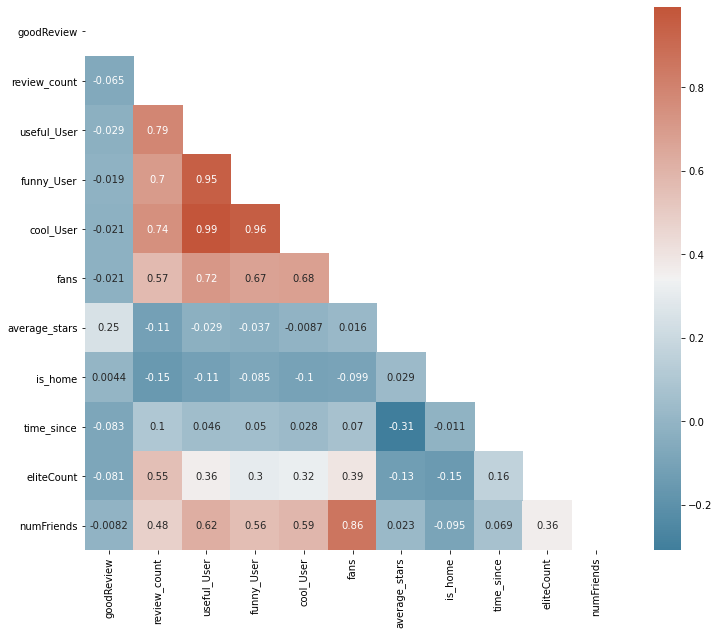

In [155]:
corrmat = dataUseful.corr()
f, ax = plt.subplots(figsize = (12, 10))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrmat, annot=True, mask = mask, cmap = cmap)
plt.show()

In [43]:
y = dataFull['goodReview']
X = dataFull.loc[:, ['review_count', 'useful_User', 'funny_User', 'cool_User', 'fans', 'average_stars', 'is_home', 'time_since', 'eliteCount', 'numFriends']]
scaler = MinMaxScaler()
X_ss = scaler.fit_transform(X)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(X_ss, y, test_size=0.3)

### KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
searchSpace = {
    'n_neighbors': range(1,20)
}

In [71]:
gs = GridSearchCV(KNeighborsClassifier(), searchSpace, cv=5, scoring = 'f1_macro')
gs.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20)}, scoring='f1_macro')

In [72]:
print(gs.best_estimator_)

KNeighborsClassifier(n_neighbors=19)


In [110]:
neigh = KNeighborsClassifier(n_neighbors=19)
neigh.fit(xtrain, ytrain)
yhat = neigh.predict(xtest)

In [111]:
knn_acc = accuracy_score(ytest, yhat)
knn_f1 = f1_score(ytest, yhat)
knn_recall = recall_score(ytest, yhat)
knn_precision = precision_score(ytest, yhat)

In [112]:
print(knn_acc)
print(knn_f1)
print(knn_recall)
print(knn_precision)

0.5779198922921576
0.547945205479452
0.5244996549344375
0.5735849056603773


### Logistic

In [125]:
clfl2 = LogisticRegression(penalty='l2').fit(xtrain, ytrain)
clfl1 = LogisticRegression(penalty='l1', solver = 'saga').fit(xtrain, ytrain)
clfelastic = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.5).fit(xtrain, ytrain)
clf = LogisticRegression(penalty='none').fit(xtrain, ytrain)

In [126]:
yhatl2 = clfl2.predict(xtest)
yhatl1 = clfl1.predict(xtest)
yhatelastic = clfelastic.predict(xtest)
yhatlogit = clf.predict(xtest)

In [129]:
models = [yhatl2, yhatl1, yhatelastic, yhatlogit]
for yhat in models:
    logit_acc = accuracy_score(ytest, yhat)
    logit_f1 = f1_score(ytest, yhat)
    logit_recall = recall_score(ytest, yhat)
    logit_precision = precision_score(ytest, yhat)
    print(logit_acc)
    print(logit_f1)
    print(logit_recall)
    print(logit_precision)
    print("-----------")

0.6088858970043757
0.5888181174805378
0.5741890959282263
0.6042120551924474
-----------
0.6085493099966341
0.5894811154253441
0.5762594893029676
0.6033236994219653
-----------
0.6088858970043757
0.5893992932862192
0.5755693581780539
0.6039102099927589
-----------
0.6085493099966341
0.5900599224532956
0.577639751552795
0.6030259365994236
-----------


### Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
searchSpace = {
    'max_depth': range(1,20),
    'min_samples_leaf': range(1,20)
}

In [80]:
gs = GridSearchCV(DecisionTreeClassifier(), searchSpace, cv=5, scoring = 'f1_macro')
gs.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 20)},
             scoring='f1_macro')

In [81]:
print(gs.best_estimator_)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=14)


In [107]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=14)
dt.fit(xtrain, ytrain)
yhat = dt.predict(xtest)

In [108]:
dt_acc = accuracy_score(ytest, yhat)
dt_f1 = f1_score(ytest, yhat)
dt_recall = recall_score(ytest, yhat)
dt_precision = precision_score(ytest, yhat)

In [109]:
print(dt_acc)
print(dt_f1)
print(dt_recall)
print(dt_precision)

0.5940760686637496
0.5008278145695364
0.41752933057280883
0.6256463288521199


### SVM

In [130]:
from sklearn.svm import SVC

In [131]:
searchSpace = {'C': [0.1,1, 10, 100], 
                'gamma': [1,0.1,0.01,0.001],
                'kernel': ['rbf', 'poly', 'sigmoid']
}

In [132]:
gs = GridSearchCV(SVC(), searchSpace, cv = 5, scoring = 'f1_macro')
gs.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='f1_macro')

In [133]:
print(gs.best_estimator_)

SVC(C=1, gamma=0.1, kernel='sigmoid')


In [135]:
svm = SVC(C = 1, gamma = 0.1, kernel = 'sigmoid')
svm.fit(xtrain, ytrain)
yhat = svm.predict(xtest)

In [136]:
svm_acc = accuracy_score(ytest, yhat)
svm_f1 = f1_score(ytest, yhat)
svm_recall = recall_score(ytest, yhat)
svm_precision = precision_score(ytest, yhat)

In [138]:
print(svm_acc)
print(svm_f1)
print(svm_recall)
print(svm_precision)

0.6075395489734097
0.5766158315177923
0.5479641131815045
0.6084291187739463


### Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
searchSpace = {
    'n_estimators': range(10,15),
    'max_depth': range(1,10),
    'min_samples_leaf': range(1,20)
}

In [142]:
gs = GridSearchCV(RandomForestClassifier(), searchSpace, cv=5, scoring='f1_macro')
gs.fit(xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
print(gs.best_estimator_)

In [143]:
rf = RandomForestClassifier(n_estimators = 15, max_depth = 5, min_samples_leaf = 15)
rf.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=15)

In [144]:
yhat = rf.predict(xtest)

In [145]:
rf_acc = accuracy_score(ytest, yhat)
rf_f1 = f1_score(ytest, yhat)
rf_recall = recall_score(ytest, yhat)
rf_precision = precision_score(ytest, yhat)

In [146]:
print(rf_acc)
print(rf_f1)
print(rf_recall)
print(rf_precision)

0.5954224166947156
0.5487987987987988
0.5044858523119393
0.6016460905349794


### Naive Bayes

In [172]:
from sklearn.linear_model import Perceptron

In [173]:
perceptron = Perceptron()
perceptron.fit(xtrain, ytrain)

Perceptron()

In [174]:
yhat = perceptron.predict(xtest)

In [179]:
perceptron.score(xtrain, ytrain)

0.5049047893825735

In [176]:
accuracy_score(yhat, ytest)

0.49612924941097275

In [178]:
f1_score(yhat, ytest)

0.6508047585724283